In [1]:
import torch 
import numpy as np
from matplotlib import pyplot as plt
import gym

In [3]:
environment_name = "Blackjack-v1"
dummy_env = gym.make(environment_name)
#dummy_env.env.get_action_meanings()
help(dummy_env.unwrapped)

Help on BlackjackEnv in module gym.envs.toy_text.blackjack object:

class BlackjackEnv(gym.core.Env)
 |  BlackjackEnv(natural=False, sab=False)
 |  
 |  Simple blackjack environment
 |  
 |  Blackjack is a card game where the goal is to obtain cards that sum to as
 |  near as possible to 21 without going over.  They're playing against a fixed
 |  dealer.
 |  Face cards (Jack, Queen, King) have point value 10.
 |  Aces can either count as 11 or 1, and it's called 'usable' at 11.
 |  This game is placed with an infinite deck (or with replacement).
 |  The game starts with dealer having one face up and one face down card, while
 |  player having two face up cards. (Virtually for all Blackjack games today).
 |  
 |  The player can request additional cards (hit=1) until they decide to stop
 |  (stick=0) or exceed 21 (bust).
 |  
 |  After the player sticks, the dealer reveals their facedown card, and draws
 |  until their sum is 17 or greater.  If the dealer goes bust the player wins.
 |  


In [4]:
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

In [85]:
#x = torch.Tensor( [[1 , 1], [1,1]], requires_grad=True)

x = torch.ones((2,2),requires_grad=True)
y = torch.sum(x) 
z = torch.float_power(y,torch.Tensor([3]))

z.backward()
print(z.grad)
print(y.grad)
print(x.grad)



None
None
tensor([[48., 48.],
        [48., 48.]])


**Linear Appoximator**

In [278]:

weights = torch.rand((1,),requires_grad=False)
bias = torch.rand((1,),  requires_grad=False)

data_points = [ (torch.Tensor([i]), torch.Tensor([20 + 30*i]) ) for i in range(20)]
inputs, actual_outputs = zip(*data_points)

inputs = torch.Tensor(inputs)
actual = torch.Tensor(actual_outputs)

alpha = 0.01
optimizer = torch.optim.Adam([weights,bias], lr=alpha)

for epoch in range(500):
    for iteration in range(20):
        input = inputs[iteration]

        predict = weights * input + bias
        diff = (predict - actual[iteration])
        loss  = 1/2*(diff)**2

        grad_weight = (diff)*input
        grad_bias = (diff)*1

        #print("Gradients: ", grad_weight, grad_bias)

        weights -=  alpha*grad_weight
        bias -=  alpha*grad_bias

    if epoch%50 == 0:
        print(f"After Epoch: {epoch}, weights: {weights}, bias: {bias}")

# for epoch in range(5000):
#     optimizer.zero_grad()
#     total_error = 0.0
#     predicted = weights*inputs + bias
#     loss = torch.mean((predicted -actual)**2)
#     total_error += loss.item()
#     loss.backward()
#     optimizer.step()
#     if epoch%200 == 0:
#         print(f"Iteration: {epoch}, Error: {total_error}")

print(f"Weights: {weights}, bias: {bias}")

After Epoch: 0, weights: tensor([30.6227]), bias: tensor([7.5638])
After Epoch: 50, weights: tensor([30.0981]), bias: tensor([18.0556])
After Epoch: 100, weights: tensor([30.0154]), bias: tensor([19.6959])
After Epoch: 150, weights: tensor([30.0023]), bias: tensor([19.9525])
After Epoch: 200, weights: tensor([30.0004]), bias: tensor([19.9925])
After Epoch: 250, weights: tensor([30.0001]), bias: tensor([19.9988])
After Epoch: 300, weights: tensor([30.0001]), bias: tensor([19.9997])
After Epoch: 350, weights: tensor([30.0001]), bias: tensor([19.9997])
After Epoch: 400, weights: tensor([30.0001]), bias: tensor([19.9997])
After Epoch: 450, weights: tensor([30.0001]), bias: tensor([19.9997])
Weights: tensor([30.0001]), bias: tensor([19.9997])


In [282]:
t = torch.rand((3,),requires_grad=True)
u = torch.rand((3,),requires_grad=True)
t = t + u
t

x = (20,20,1)

torch.Tensor(x)

wt = torch.Tensor((1,3.0,0.3))
wt.requires_grad = True
y = wt**2 + wt
x = torch.Tensor((1,3,4))
h = torch.sum(x*y)
h.backward()

print(wt.grad)

# clear out gradient
if wt.grad is not None:
    wt.grad.data.zero_()

wt.grad


tensor([ 3.0000, 21.0000,  6.4000])


tensor([0., 0., 0.])

**Linear/Non Linear State Value Function Approx using Monte Carlo**

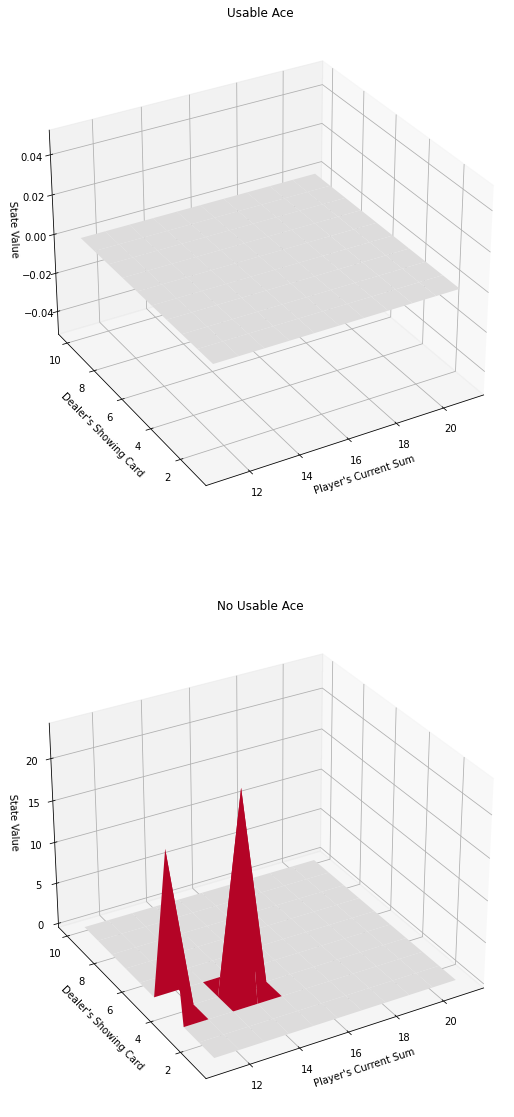

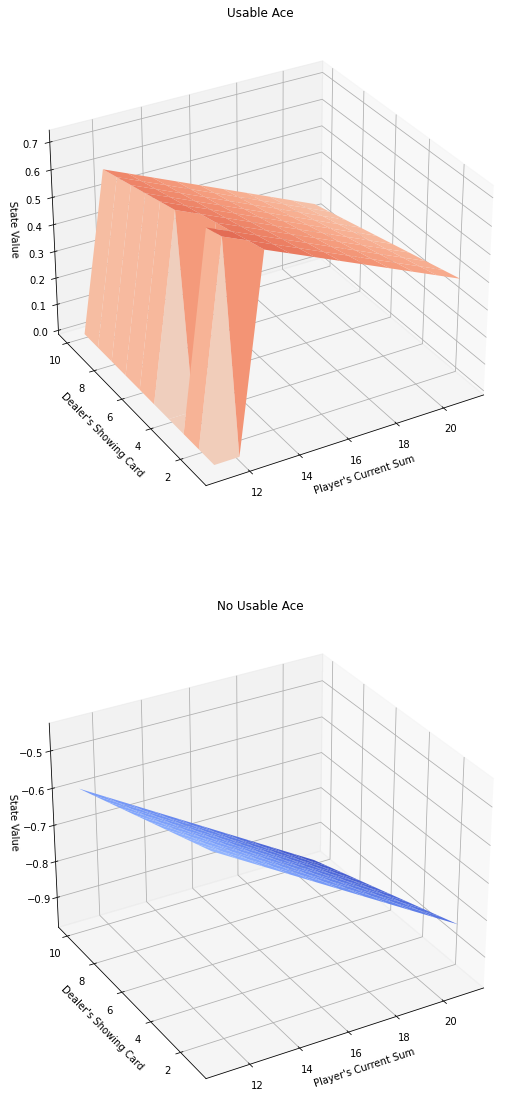

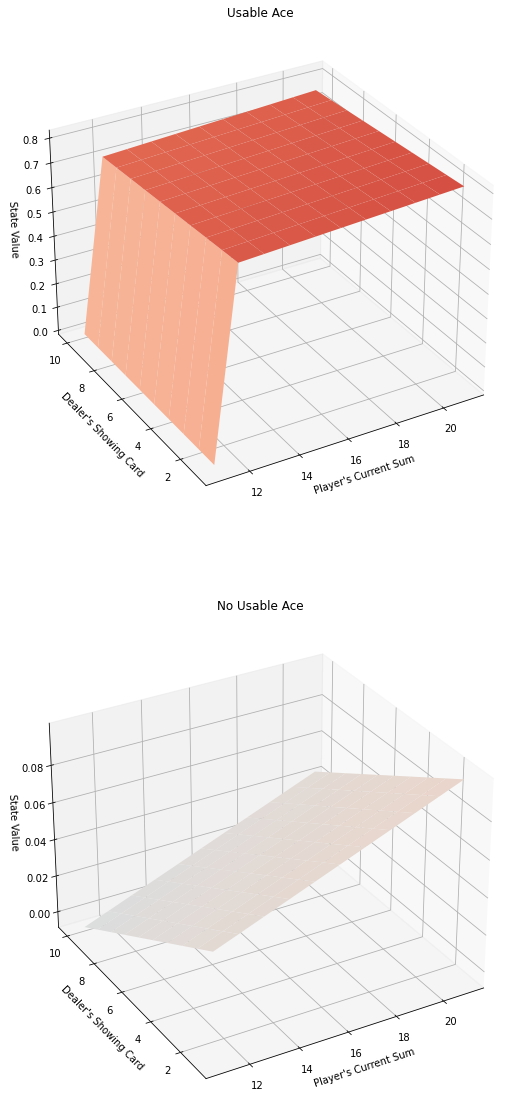

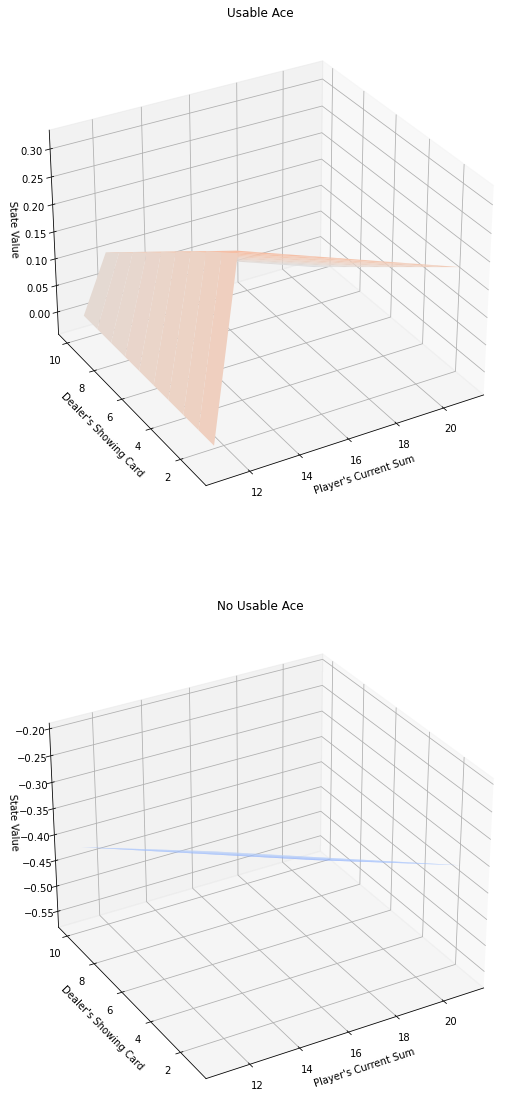

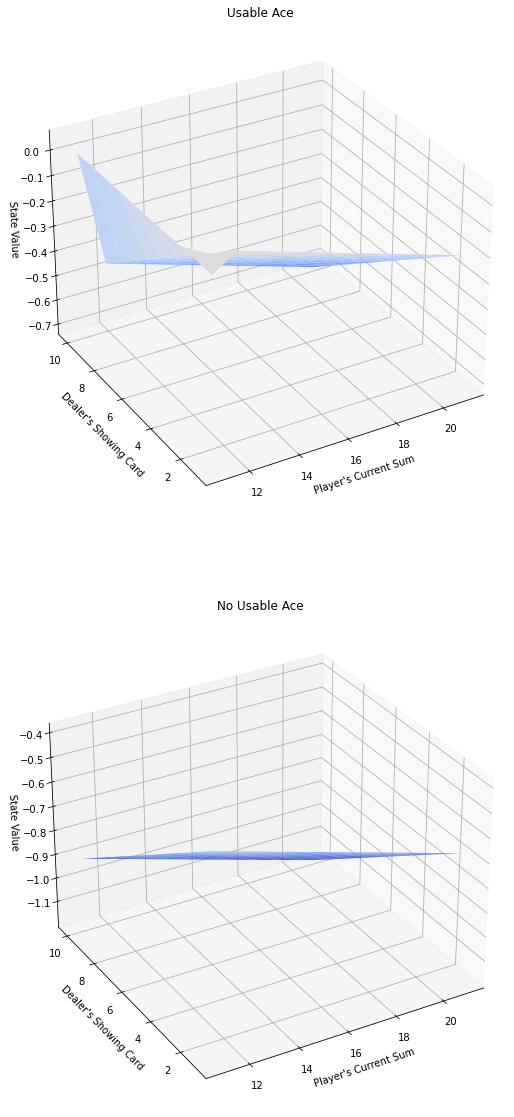

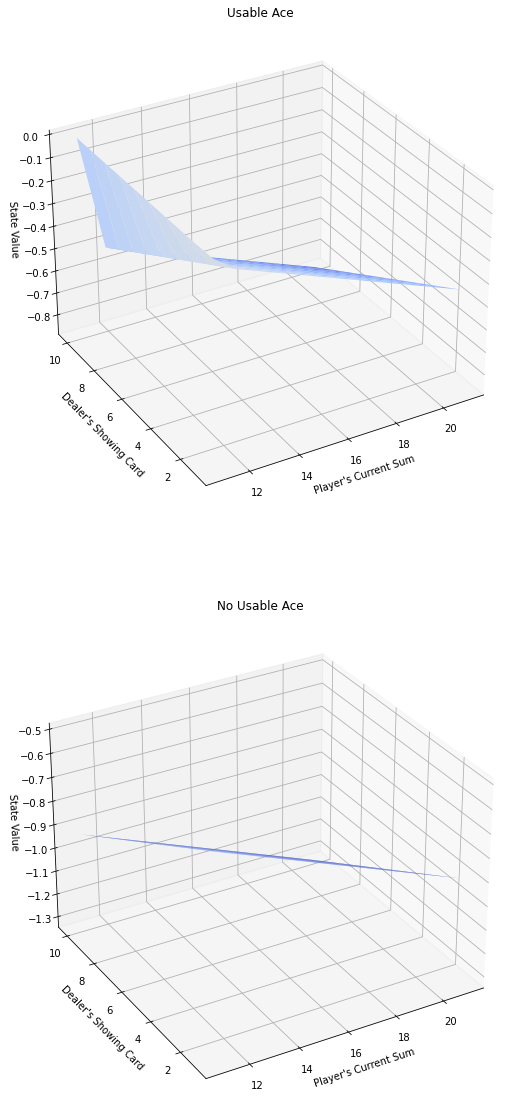

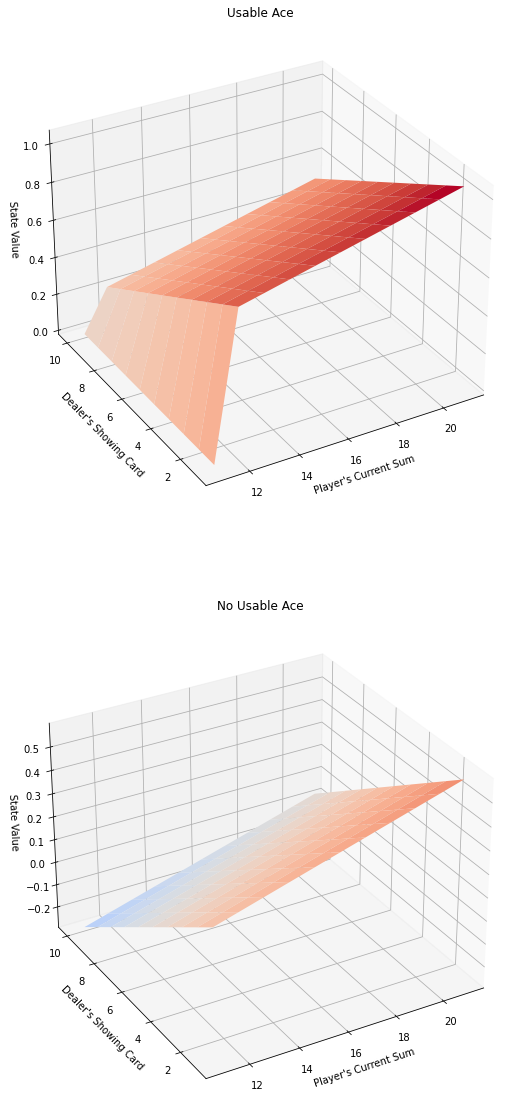

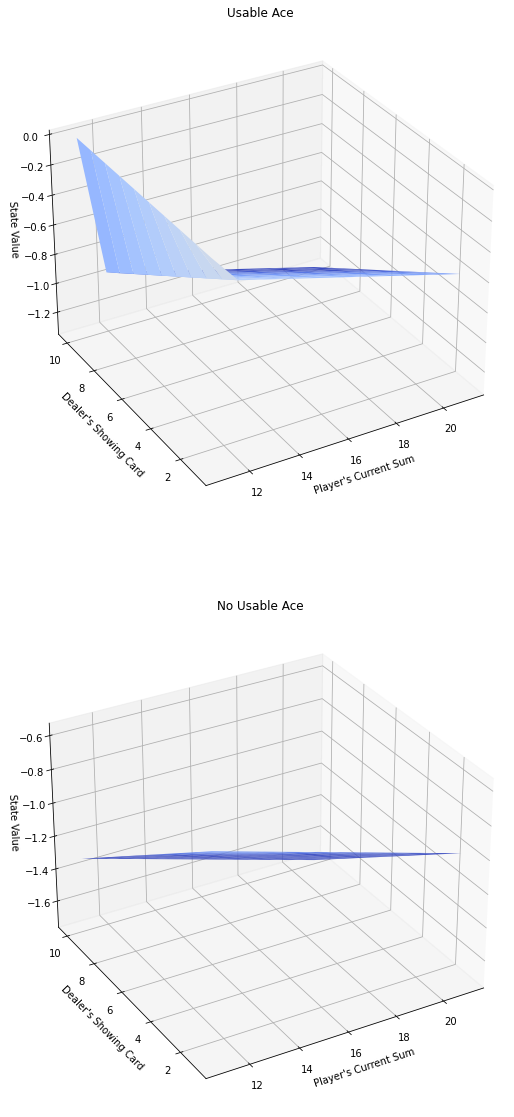

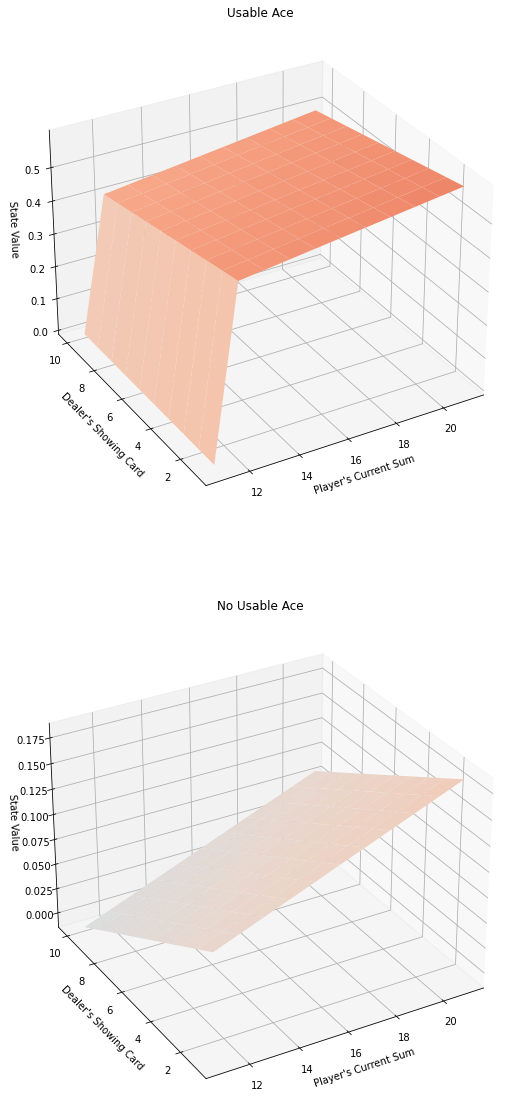

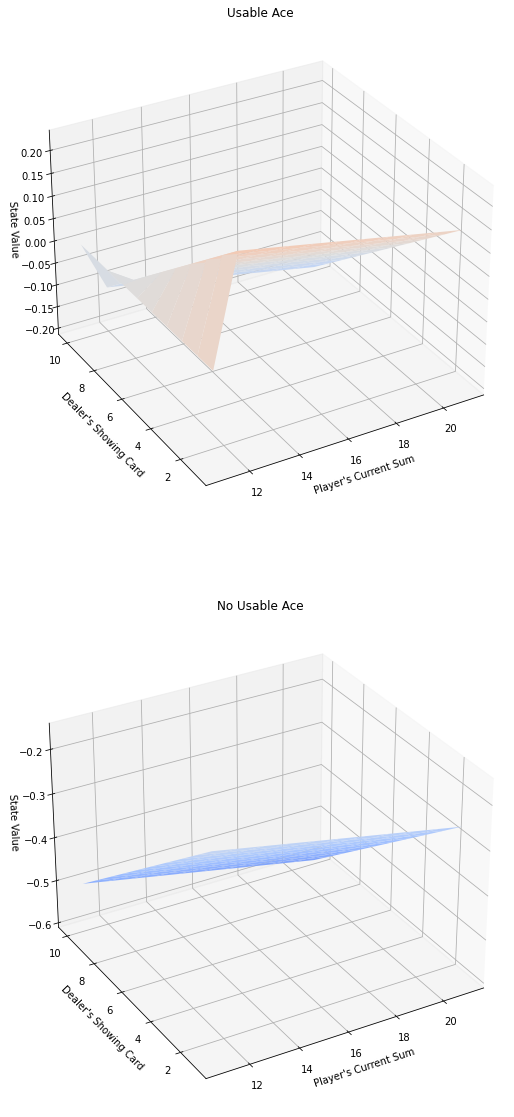

tensor([ 0.0086, -0.0043,  0.1356], requires_grad=True)


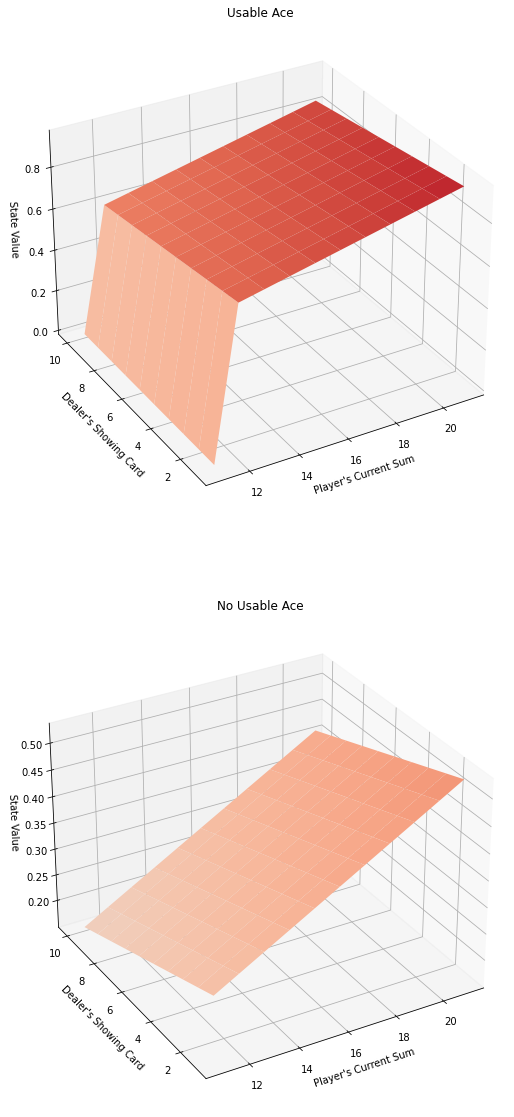

In [269]:
environment_name = "Blackjack-v1"

from dataclasses import dataclass
from collections import defaultdict, Counter

class BlackJackValueAppoximationAgent:
    MAX_PLAYER_SUM = 32
    MAX_DEALER_CARD = 11
    MAX_ACE_STATE = 2

    def __init__(self, env: gym.Env):
        self.environment = env
        self.total_actions = 2
        self.gamma = 0.8
        self.alpha = 0.0001

        # assume value function could be approxiated by linear model
        #num_states = self.MAX_ACE_STATE * self.MAX_DEALER_CARD * self.MAX_PLAYER_SUM
        #total_hot_endcoded_states = self.MAX_ACE_STATE + self.MAX_DEALER_CARD + self.MAX_PLAYER_SUM
        #self.weights = torch.rand((total_hot_endcoded_states,),requires_grad=True)
        #self.dummy_state = torch.rand((num_states,))
        
        self.weights = torch.rand((3,),requires_grad=True)

        self.optimizer = torch.optim.Adam( [self.weights], lr = 0.001)

        self.state_tracker = defaultdict(bool)

    @staticmethod
    def compute_hot_encoded_state(state):
        def one_hot_encoded(state: int, max_state: int):
            return np.array([ (1 if i == state else 0)  for i in range(1,max_state+1)])

        def one_hot_encoded_boolean(state: bool):
            return np.array([1,0]) if state else np.array([0, 1])

        player_sum, dealer_card, is_useable_ace = state

        players = one_hot_encoded(player_sum,BlackJackValueAppoximationAgent.MAX_PLAYER_SUM)
        dealers = one_hot_encoded(dealer_card,BlackJackValueAppoximationAgent.MAX_DEALER_CARD)
        aces = one_hot_encoded_boolean(is_useable_ace)

        temp = np.append(players, dealers)
        return np.append(temp, aces)

    def choose_action(self, state):
        player_sum, dealer_card, is_usable_ace = state
        probabilities = [0.75, 0.25] if player_sum > 18 else [0.25, 0.75]
        return np.random.choice(self.total_actions, p=probabilities)

    def estimate_value_tensor_from_state(self, state):
        dummy_state = torch.Tensor(state)
        non_linear = self.weights**2 + 3*self.weights
        estimated_value = torch.sum(non_linear * dummy_state)
        return estimated_value

    def update_value_functions(self,episode):
        states, actions, rewards, next_states = zip(*episode)

        discount_factors = [self.gamma**i for i in range(len(states) + 1) ]

        for i, state in enumerate(states):
            expected_return = np.dot(rewards[i:], discount_factors[: -(i+1) ])
            #expected_return = rewards[i] + self.gamma*self.estimate_value_from_state(next_state[i])

            current_state_tensor = self.estimate_value_tensor_from_state(state)
            current_state_expected = current_state_tensor.item()

           # print("Before grad: ", self.weights, self.weights.grad, state)

            self.state_tracker[state] = False

            if self.weights.grad is not None:
                self.weights.grad.data.zero_()

            current_state_tensor.backward()
            #print("After grad: ", self.weights, self.weights.grad, state)

            diff_weights = self.alpha*(expected_return - current_state_expected)*self.weights.grad
            #print("Error diff", expected_return, current_state_expected, diff_weights)

            with torch.no_grad():
                self.weights += diff_weights
            #optimizer.zero_grad()

    def generate_episode(self):
        episode = []
        state = self.environment.reset()
        self.optimizer.zero_grad()
        while True:
            action = self.choose_action(state)
            next_state, reward, is_done, _ = self.environment.step(action)
            episode.append( (state,action,reward,next_state) )
            if is_done:
                break
            state = next_state
        return episode


epsilon_start = 1.0
epsilon_end = 0.05 
epsilon = epsilon_start
epsilon_decay = 0.995
lambda_value = 0.05

launch_environment = gym.make(environment_name)

agent = BlackJackValueAppoximationAgent(launch_environment)

for i in range(50000):
    episode = agent.generate_episode()

    agent.update_value_functions(episode)

    if i%5000 == 0:
        action_values = dict((state, agent.estimate_value_tensor_from_state(state).detach().item() ) 
            for state, _ in agent.state_tracker.items())
        plot_blackjack_values(action_values)

print(agent.weights)

action_values = dict((state, agent.estimate_value_tensor_from_state(state).detach().item() ) 
    for state, _ in agent.state_tracker.items())
plot_blackjack_values(action_values)

**Linear State Value Function Approx using TD(0)**

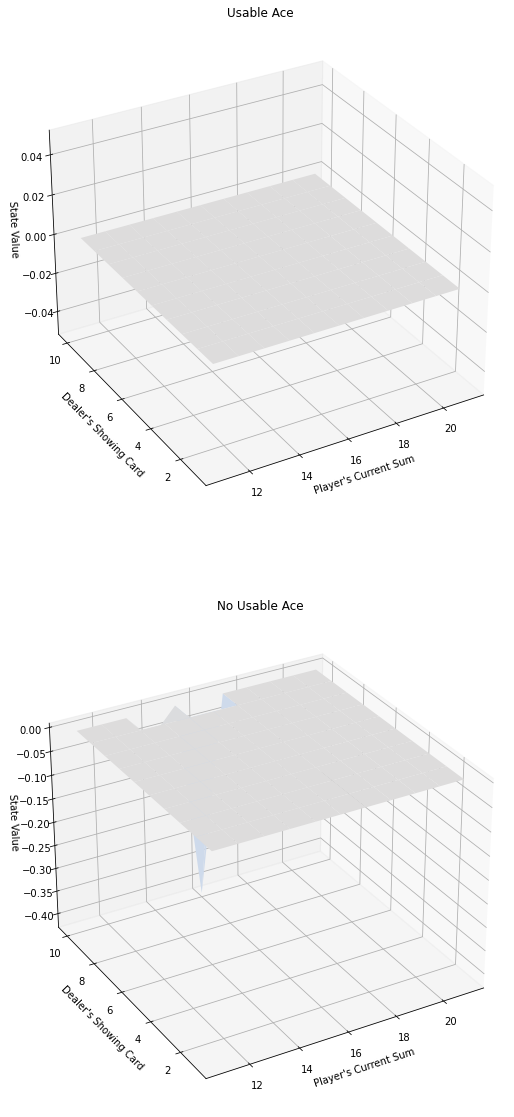

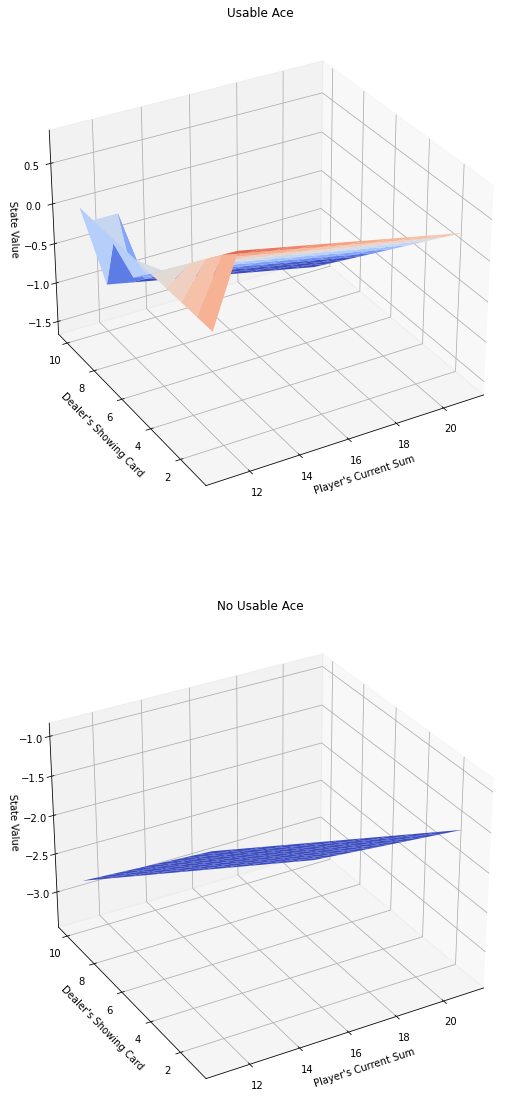

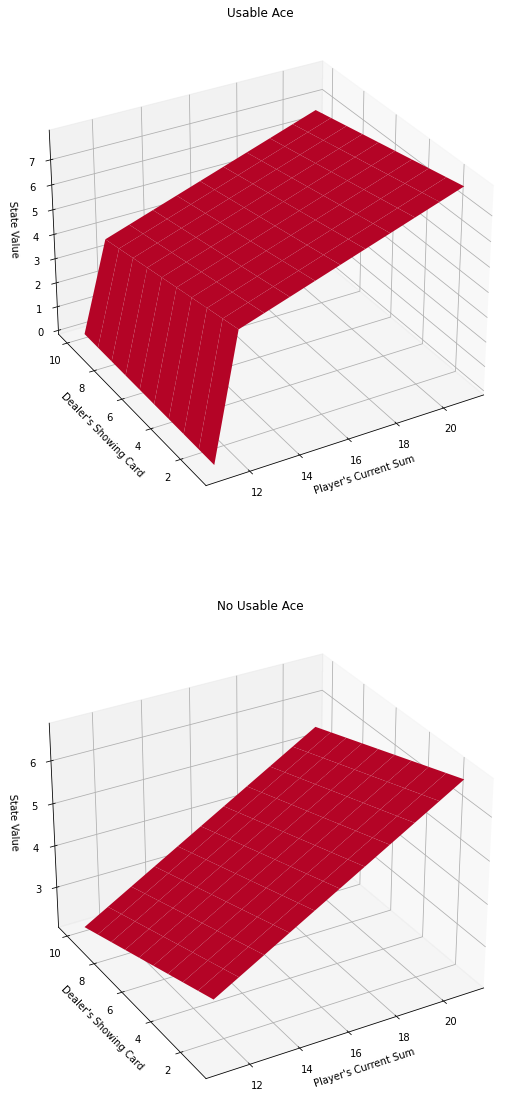

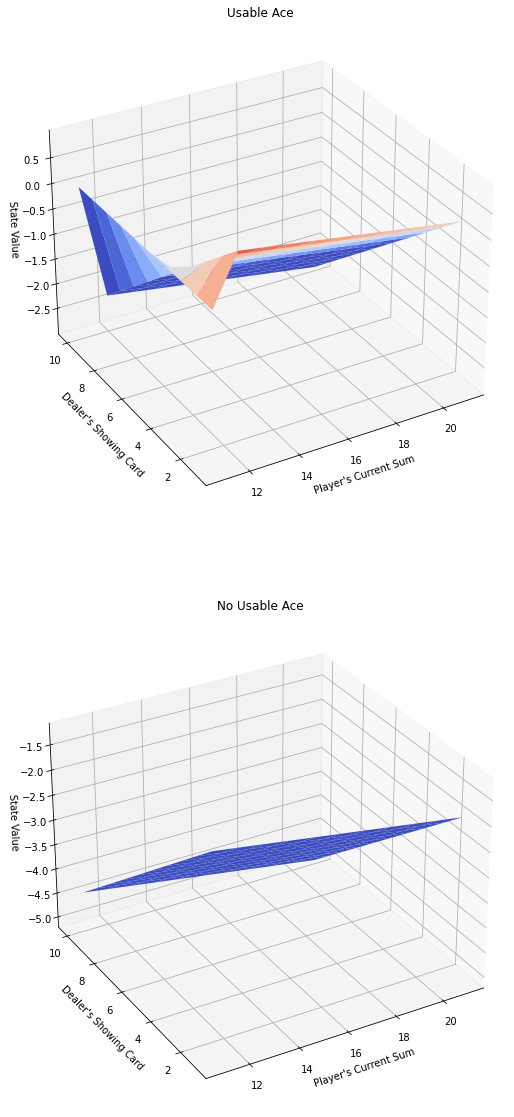

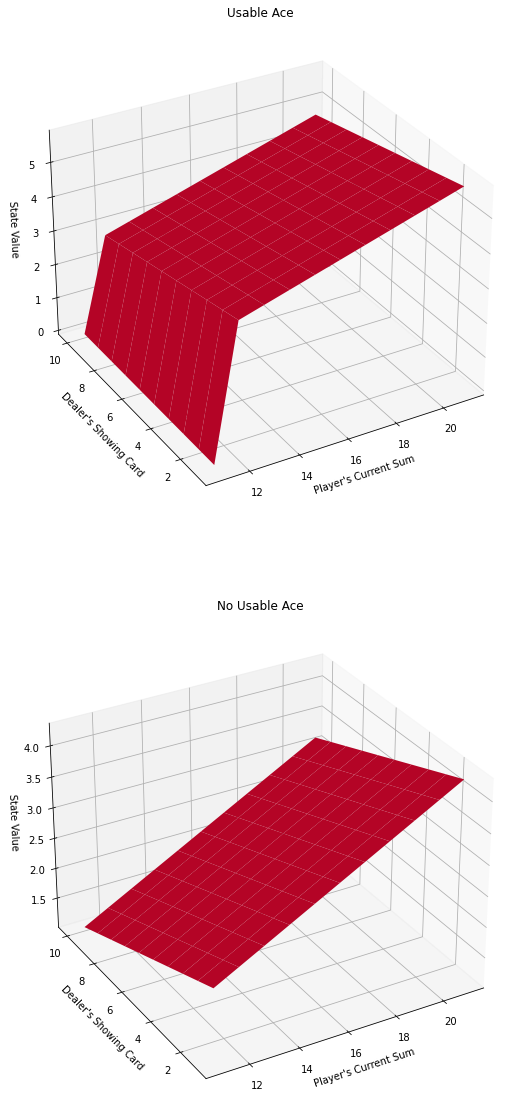

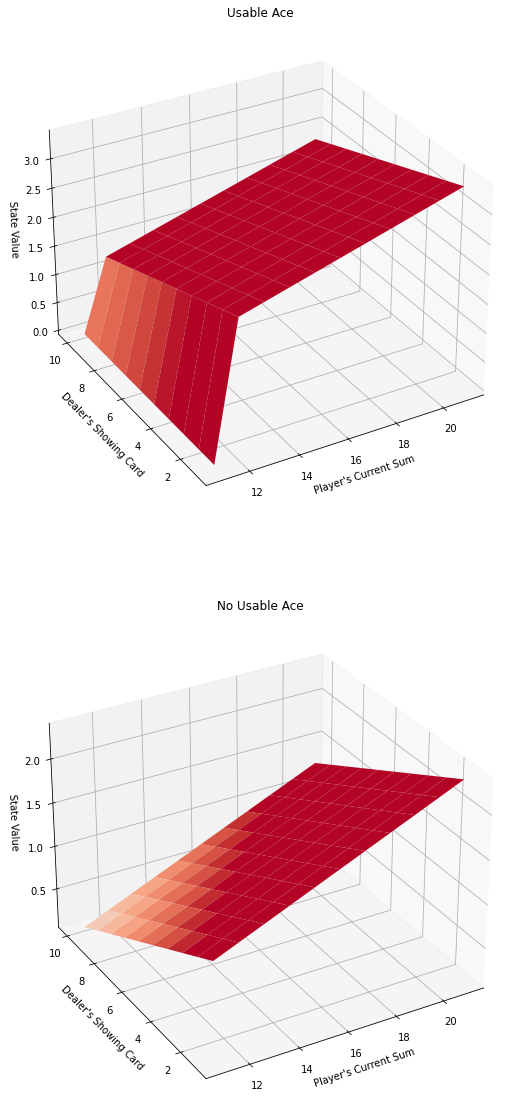

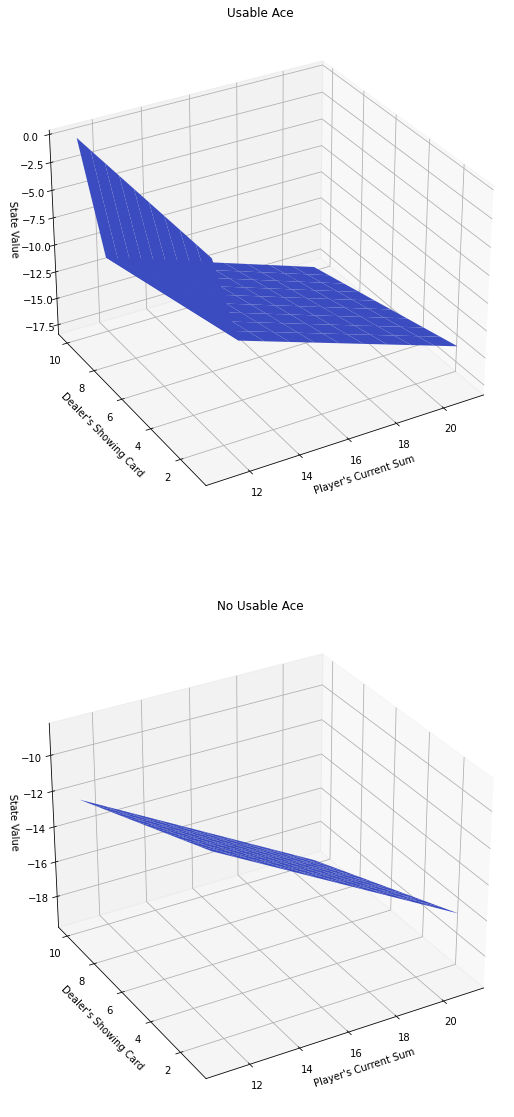

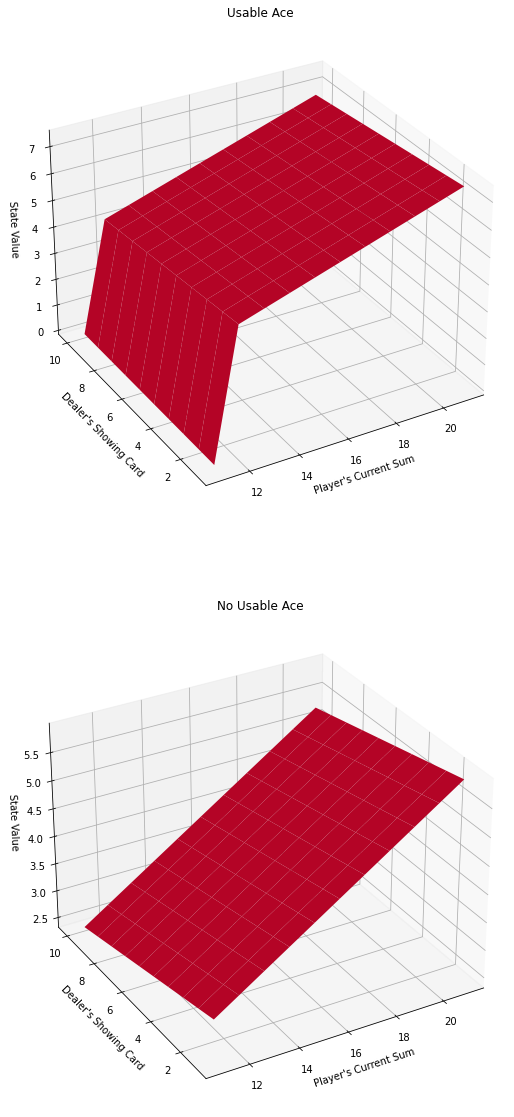

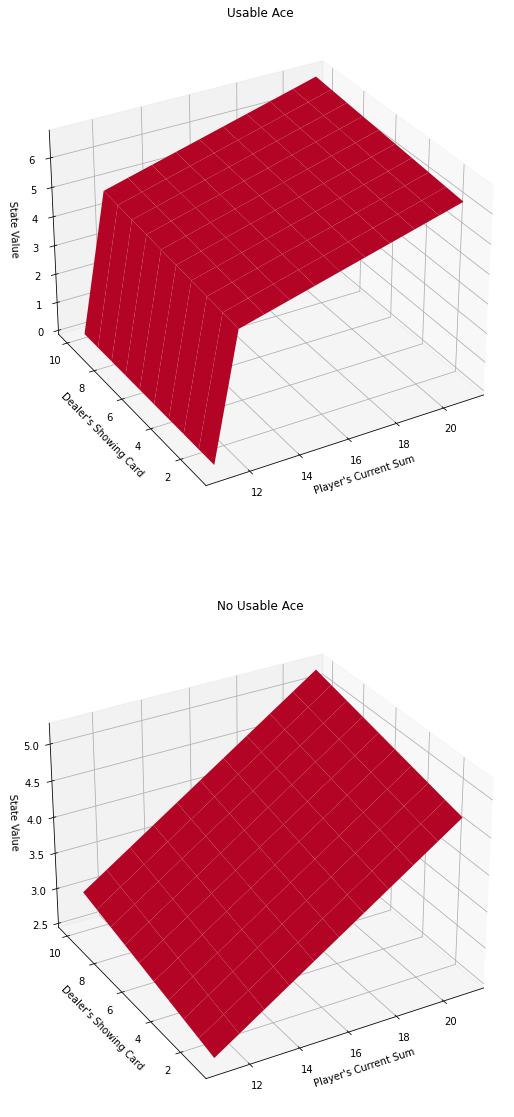

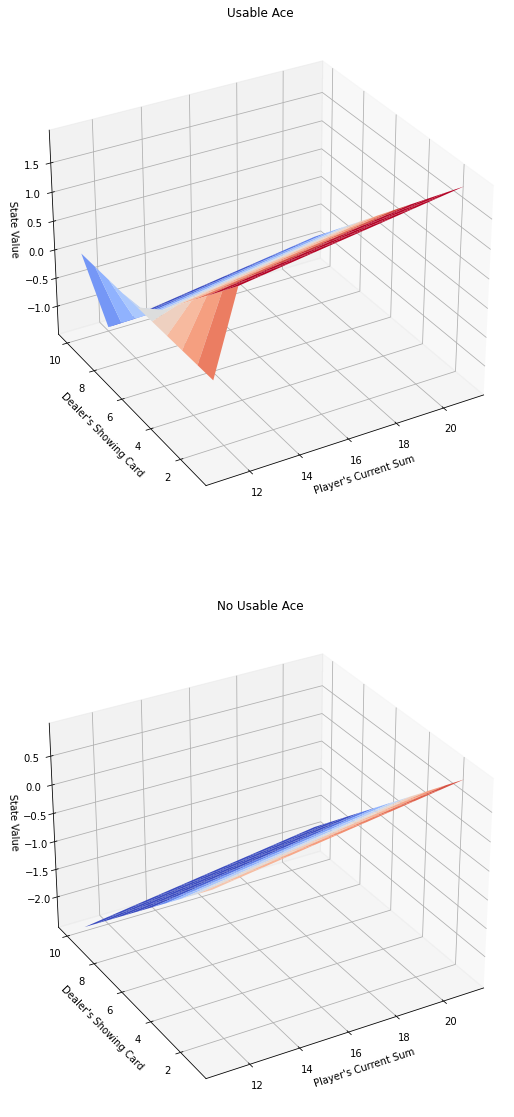

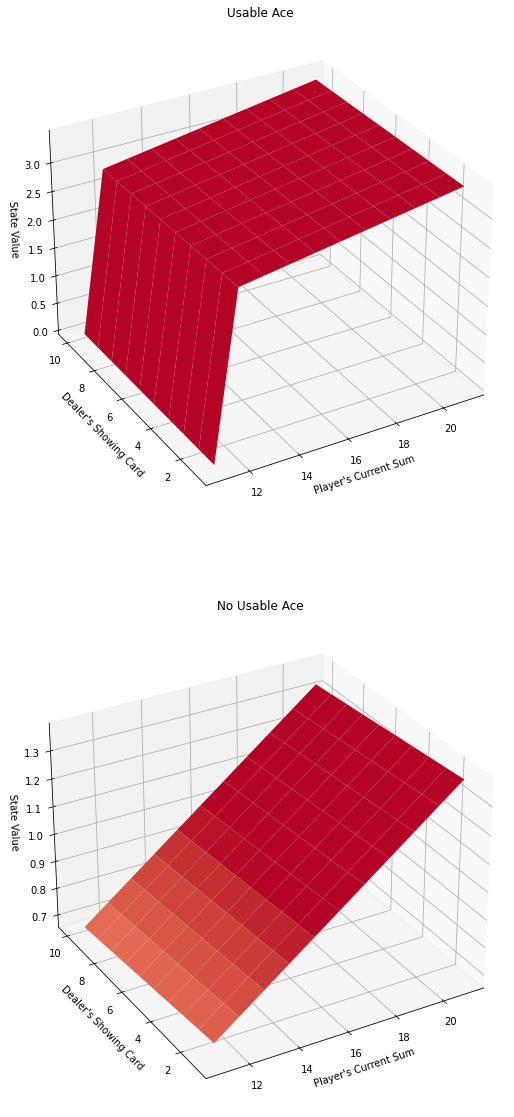

tensor([ 0.0661, -0.0059,  2.1075], requires_grad=True)
tensor(3.3044, grad_fn=<SumBackward0>)


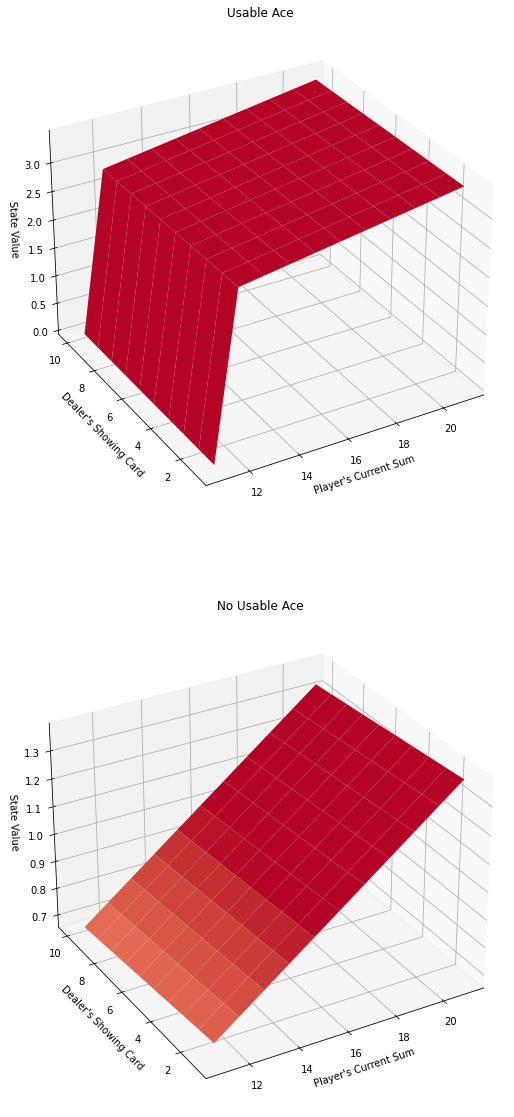

In [275]:
environment_name = "Blackjack-v1"

from dataclasses import dataclass
from collections import defaultdict, Counter

class BlackJackValueAppoximationAgentOnline:
    MAX_PLAYER_SUM = 32
    MAX_DEALER_CARD = 11
    MAX_ACE_STATE = 2

    def __init__(self, env: gym.Env):
        self.environment = env
        self.total_actions = 2
        self.gamma = 0.8
        self.alpha = 0.01

        self.state_tracker = defaultdict(bool)

        # assume value function could be approxiated by linear model
        #num_states = self.MAX_ACE_STATE * self.MAX_DEALER_CARD * self.MAX_PLAYER_SUM
        #total_hot_endcoded_states = self.MAX_ACE_STATE + self.MAX_DEALER_CARD + self.MAX_PLAYER_SUM
        #self.weights = torch.rand((total_hot_endcoded_states,),requires_grad=True)
        #self.dummy_state = torch.rand((num_states,))
        
        self.weights = torch.rand((3,),requires_grad=True)
        self.optimizer = torch.optim.Adam( [self.weights], lr = 0.001)

    @staticmethod
    def compute_hot_encoded_state(state):
        def one_hot_encoded(state: int, max_state: int):
            return np.array([ (1 if i == state else 0)  for i in range(1,max_state+1)])

        def one_hot_encoded_boolean(state: bool):
            return np.array([1,0]) if state else np.array([0, 1])

        player_sum, dealer_card, is_useable_ace = state

        players = one_hot_encoded(player_sum,BlackJackValueAppoximationAgent.MAX_PLAYER_SUM)
        dealers = one_hot_encoded(dealer_card,BlackJackValueAppoximationAgent.MAX_DEALER_CARD)
        aces = one_hot_encoded_boolean(is_useable_ace)

        temp = np.append(players, dealers)
        return np.append(temp, aces)

    def choose_action(self, state):
        player_sum, dealer_card, is_usable_ace = state
        probabilities = [0.75, 0.25] if player_sum > 18 else [0.25, 0.75]
        return np.random.choice(self.total_actions, p=probabilities)

    def estimate_value_tensor_from_state(self, state):
        dummy_state = torch.Tensor(state)
        estimated_value = torch.sum(self.weights * dummy_state)
        return estimated_value

    def update_during_episode(self):
        state = self.environment.reset()
        while True:
            action = self.choose_action(state)
            next_state, reward, is_done, _ = self.environment.step(action)

            estimated_next_state_value = self.estimate_value_tensor_from_state(next_state).item()
            state_tensor = self.estimate_value_tensor_from_state(state)

            state_value = state_tensor.item()
            error_term = (reward + self.gamma*estimated_next_state_value - state_value )

            if self.weights.grad is not None: 
                self.weights.grad.data.zero_()
            state_tensor.backward()
            #print("After gradient update: ", self.weights, self.weights.grad, state)

            gradient_estimated = self.weights.grad
            diff_gradient = self.alpha * error_term * gradient_estimated

            with torch.no_grad():
                self.weights += diff_gradient

            #print("Final WT & gradient: ", self.weights, self.weights.grad, state)
            #print("***********************")

            self.state_tracker[state] = False

            if is_done:
                break
            state = next_state
            # self.V[state] = reward + self.gamme*self.V[next_state]
            # diff_gradient = self.alpha * ( exp_reward - self.V[next_state]) * gradient( Value_function )

epsilon_start = 1.0
epsilon_end = 0.05 
epsilon = epsilon_start
epsilon_decay = 0.995
lambda_value = 0.05

launch_environment = gym.make(environment_name)

agent = BlackJackValueAppoximationAgentOnline(launch_environment)

for i in range(50001):
    agent.update_during_episode()

    if i % 5000 == 0:
        action_values = dict((state, agent.estimate_value_tensor_from_state(state).detach() ) for state, _ in agent.state_tracker.items())
        plot_blackjack_values(action_values)

print(agent.weights)
print( agent.estimate_value_tensor_from_state( (19,10,1) ) )

action_values = dict((state, agent.estimate_value_tensor_from_state(state).detach() ) for state, _ in agent.state_tracker.items())
plot_blackjack_values(action_values)

